## Importing Libraries

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

## Importing Data

In [3]:
df = pd.read_csv('daily-min-temp.csv')

In [4]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [6]:
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [7]:
print('Time period start: {}\nTime period end: {}'.format(df.Date.min(),df.Date.max()))

Time period start: 1981-01-01
Time period end: 1990-12-31


## Data Pre-processing and Visualization

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [10]:
y = df.set_index('Date')

In [11]:
y.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04', '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08', '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25', '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29', '1990-12-30', '1990-12-31'], dtype='datetime64[ns]', name='Date', length=3650, freq=None)

In [12]:
y.isnull().sum()

Temp    0
dtype: int64

Plotting the temperatures over time as time series plot

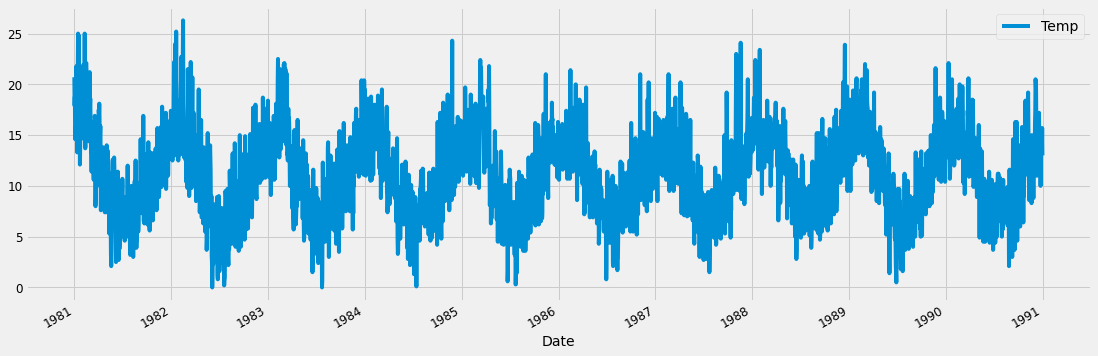

In [13]:
y.plot(figsize=(17,6))
plt.show()

Plotting histogram for temperatures

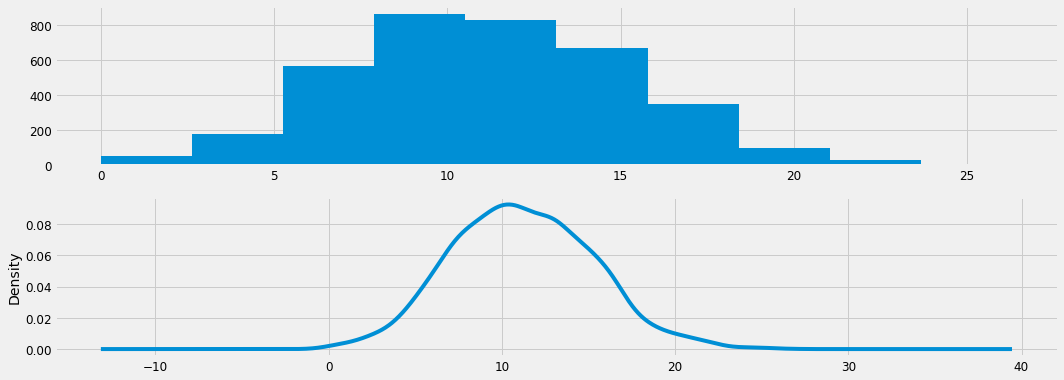

In [14]:
from pandas import Series
from matplotlib import pyplot

pyplot.figure(1)
pyplot.subplot(211)
y.Temp.hist()
pyplot.subplot(212)
y.Temp.plot(kind='kde', figsize=(16,6))
pyplot.show()

Seems like the temperatures are normally distributed

Yearly patterns

<AxesSubplot:xlabel='Date', ylabel='Temp'>

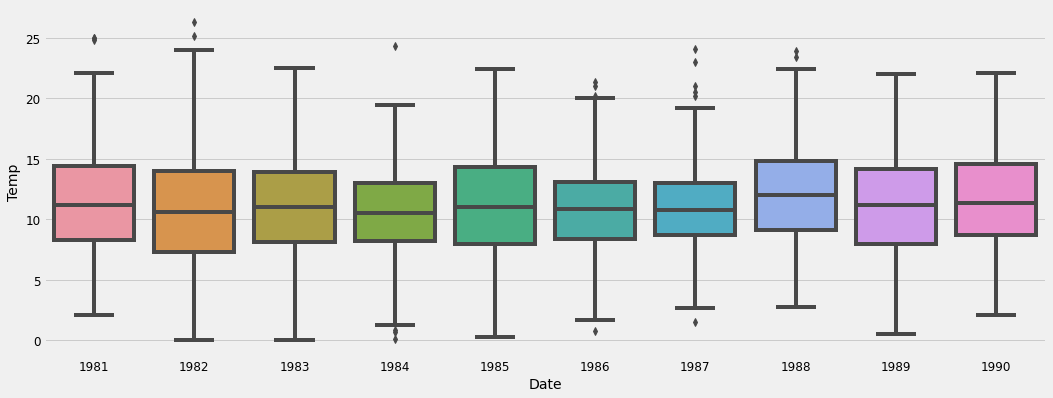

In [15]:
fig, ax = plt.subplots(figsize=(16,6))
sns.boxplot(y.Temp.index.year, y.Temp, ax=ax)

Montly patterns

<AxesSubplot:xlabel='Date', ylabel='Temp'>

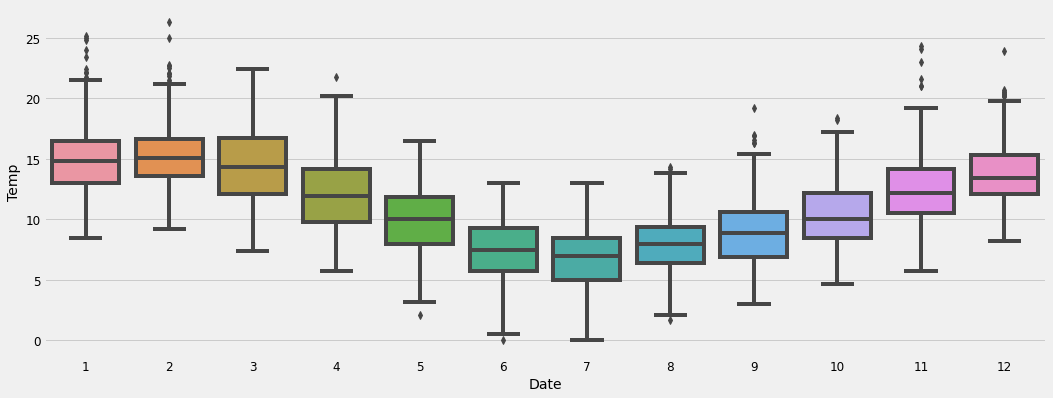

In [16]:
fig, ax = plt.subplots(figsize=(16,6))
sns.boxplot(y.Temp.index.month, y.Temp, ax=ax)

#### Decomposing Time series using statsmodels

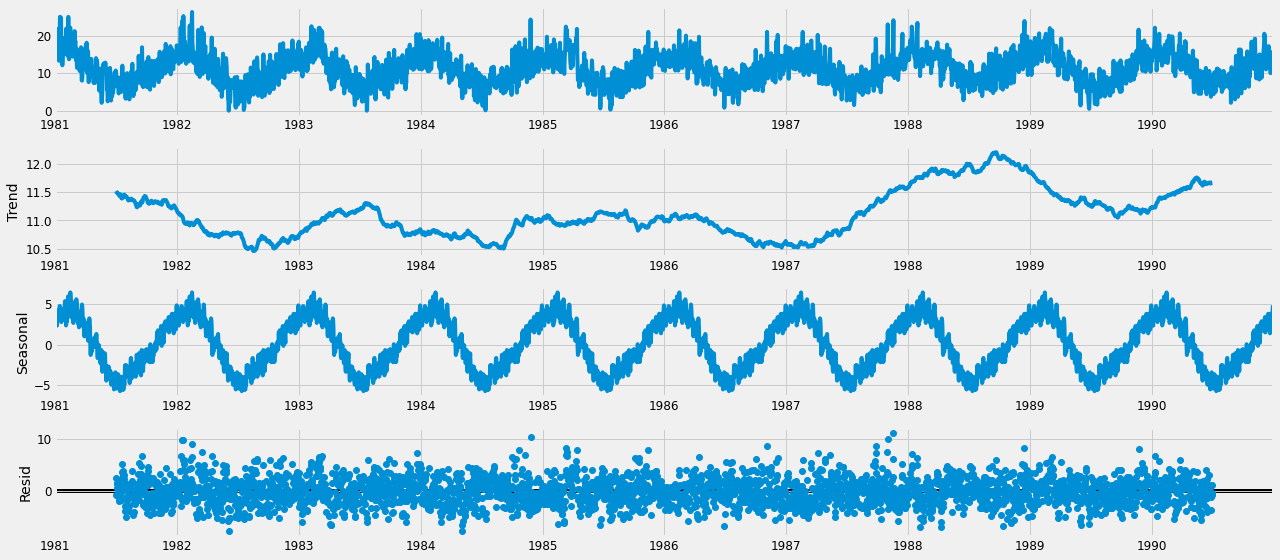

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = 365)
fig = decomposition.plot()
plt.show()

In [18]:
trend = decomposition.trend

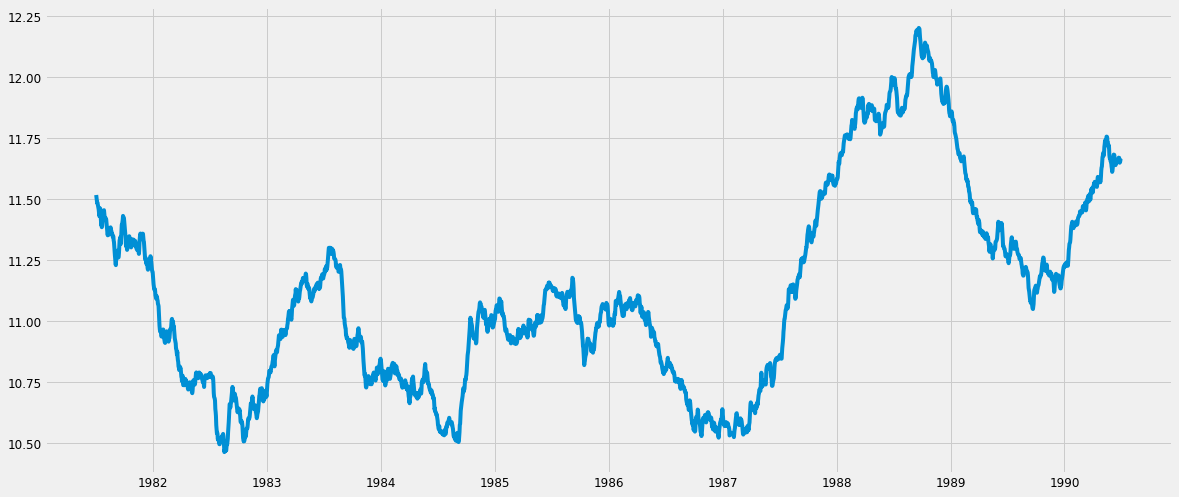

In [19]:
plt.plot(trend)

#### Stationarity

- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.

- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.

- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

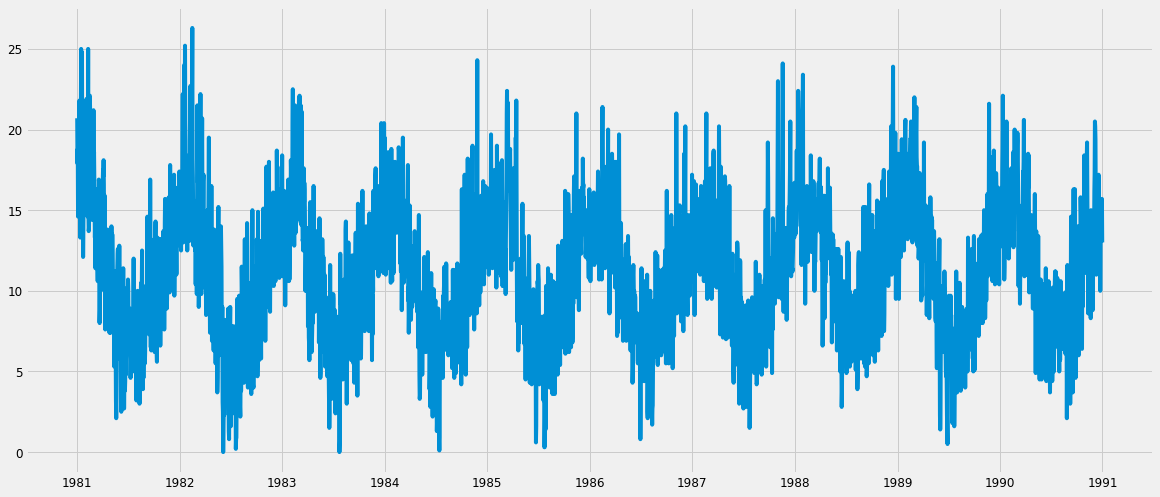

In [20]:
plt.plot(y)

__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

### ACF and PACF plots

- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

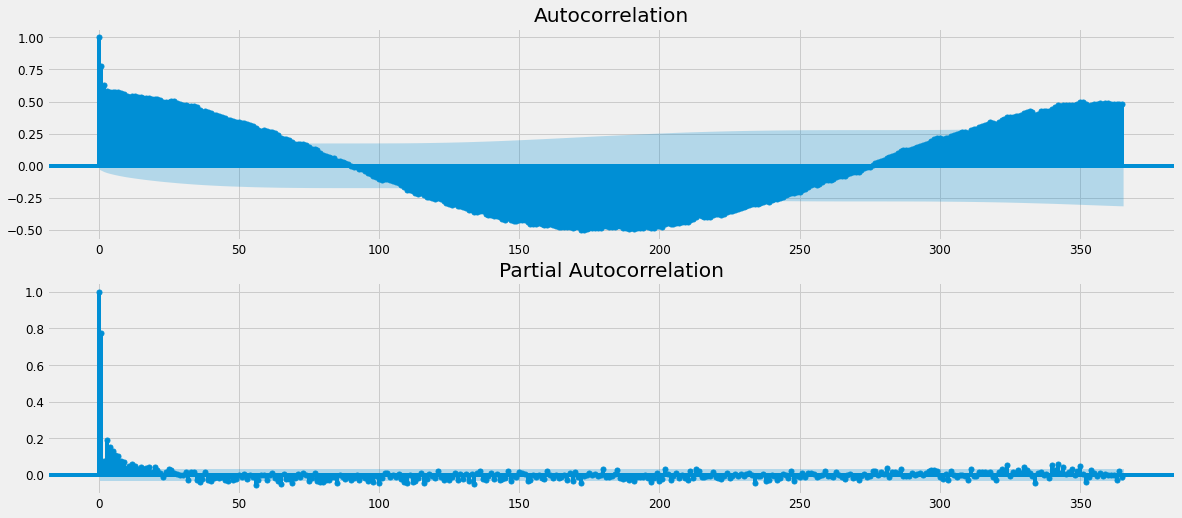

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.Temp, ax=pyplot.gca(), lags=365)
pyplot.subplot(212)
plot_pacf(y.Temp, ax=pyplot.gca(), lags=365)
pyplot.show()

### Plotting Rolling Statistics

- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

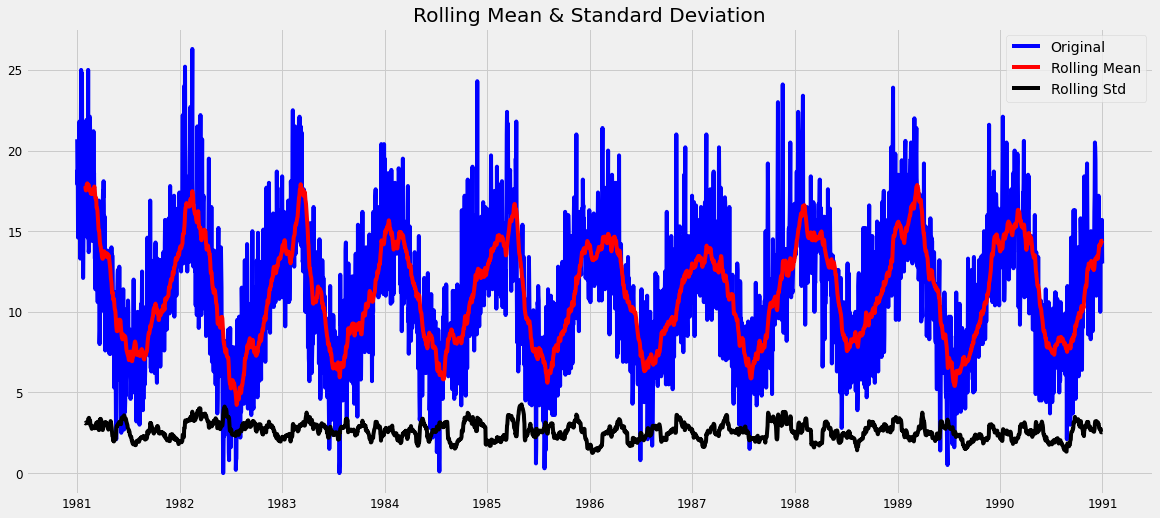

In [31]:
#Determing rolling statistics

rolmean = y.rolling(window = 30).mean()

rolstd = y.rolling(window = 30).std()

#plot rolling statistics:

orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)